<img src="../Img/banner-fa-49-2.jpg">
13 апреля 2021 года, ВМ/305-1(кк)

# Тема 5. Анализ временных рядов

Студенты: Поток У18-7у<br>
Преподаватель: Смирнов Михаил Викторович, доцент Департамента Анализа данных и машинного обучения Финансового университета при Правительстве Российской Федерации

## Задача о разделении столбца
В текстовом файле содержатся данные о динамике курса йены к доллару в течение года. Данные представлены так, что дата торгов и цена йены содержатся в чередующихся записях одного столбца. Кроме того, эти данные условно подразделяются на разделы (блоки) по месяцам, в начале каждого раздела присутствует служебная строка "История обменного курса ... за Дек 2019", затем " ... за Ноя 2019" и так далее. На рисунке представлен фрагмент файла.

<img src="./Img/notepad.png">

## Задание
1. Разделить данные на два столбца, так, чтобы цена оказалась в соседнем столбце напротив даты. 
2. Найти линейную модель данных.
3. Построить график временного ряда и график модели.
4. Провести сглаживание, построить гистограмму остатков.
5. Оценить качество модели с помощью $R^2$

Примечание. Источник данных на сайте: https://freecurrencyrates.com/ru/exchange-rate-history/JPY-USD/2019/cbr Для копирования данных в текстовый файл использовались программы Mozilla Firefox и Блокнот Windows.

## Решение

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot

Чтобы иметь представление о том, что это за файл, прочитаем его с помощью функции *open()* и отобразим несколько первых строк.

In [2]:
source_file_name = './Data/Currency_JPY_USD_2019.txt'
source_file = open(source_file_name, 'r', encoding='utf-8')
source_file.readlines()[0:10]

['https://freecurrencyrates.com/ru/exchange-rate-history/JPY-USD/2019/cbr\n',
 'История обменного курса JPY/USD (Иена/Доллар США) за Дек 2019 года (12.2019)\n',
 'Дек 31\n',
 '0.00916\n',
 'Дек 28\n',
 '0.00913\n',
 'Дек 27\n',
 '0.00913\n',
 'Дек 26\n',
 '0.00914\n']

Представим данные в табличном виде. Не будем помещать в таблицу две первых и последнюю строки, так как они не содержат нужных нам данных.

In [3]:
df = pd.read_csv(source_file_name, skiprows=2, names=['Currency'])[:-1]

Отобразим краткую информацию об этой таблице

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Currency  503 non-null    object
dtypes: object(1)
memory usage: 4.1+ KB


Мы видим, что в таблице один столбец. Число его непустых значений указано в колонке *Non-Null Count*. Кроме того, тип данных определен как *object*, это значит, что Python все значения столбца считает текстовыми.

In [5]:
df

,Currency
0,Дек 31
1,0.00916
2,Дек 28
3,0.00913
4,Дек 27
...,...
498,0.00923
499,Янв 11
500,0.00927
501,Янв 10


Часть строк файла содержит служебную информацию, начинающуюся со слова "История". Пока просто сосчитаем их.

In [6]:
df[df['Currency'].str.contains("История")].count()

Currency    11
dtype: int64

Например

In [7]:
df.iloc[41:45]

,Currency
41,0.00912
42,История обменного курса JPY/USD (Иена/Доллар С...
43,Ноя 30
44,0.00913


Исключим такие строки с помощью фильтра.

In [8]:
df = df[~df['Currency'].str.contains("История")]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 0 to 502
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Currency  492 non-null    object
dtypes: object(1)
memory usage: 7.7+ KB


Обратим внимание на значение *Non-Null Count*. Количество строк в таблице уменьшилось. Создадим серию с данными о датах.

In [9]:
Dates = pd.Series(df['Currency'][::2])

Создадим серию с данными о ценах

In [10]:
Prices = pd.Series(df['Currency'][1::2])

Посмотрим, что получилось

In [11]:
Dates

0      Дек 31
2      Дек 28
4      Дек 27
6      Дек 26
8      Дек 25
        ...  
493    Янв 16
495    Янв 15
497    Янв 12
499    Янв 11
501    Янв 10
Name: Currency, Length: 246, dtype: object

In [12]:
Prices

1      0.00916
3      0.00913
5      0.00913
7      0.00914
9      0.00914
        ...   
494    0.00920
496    0.00925
498    0.00923
500    0.00927
502    0.00918
Name: Currency, Length: 246, dtype: object

Обе серии содержат равное число элементов. Объединим две серии в набор.

In [13]:
H = pd.DataFrame({'Date':Dates, 'Price':Prices})
H

,Date,Price
0,Дек 31,NaN
1,NaN,0.00916
2,Дек 28,NaN
3,NaN,0.00913
4,Дек 27,NaN
...,...,...
498,NaN,0.00923
499,Янв 11,NaN
500,NaN,0.00927
501,Янв 10,NaN


Колонку Dates сдвинем на одну позицию вниз.

In [14]:
H['Date']=H['Date'].shift(1)
H.head()

,Date,Price
0,NaN,NaN
1,Дек 31,0.00916
2,NaN,NaN
3,Дек 28,0.00913
4,NaN,NaN


Применим фильтр, чтобы избавиться от строк NaN.

In [15]:
H = H[(H['Date'].isnull()==False) & (H['Price'].isnull()==False)]
H.head()

,Date,Price
1,Дек 31,0.00916
3,Дек 28,0.00913
5,Дек 27,0.00913
7,Дек 26,0.00914
9,Дек 25,0.00914


Обратим данные, так, чтобы январь был сверху, а декабрь внизу и переиндексируем.

In [16]:
H = H[::-1]
H.index = range(0, len(H))
H.head()

,Date,Price
0,Янв 10,0.00918
1,Янв 11,0.00927
2,Янв 12,0.00923
3,Янв 15,0.00925
4,Янв 16,0.00920


In [17]:
H.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    246 non-null    object
 1   Price   246 non-null    object
dtypes: object(2)
memory usage: 4.0+ KB


Приведем значения столбца цены к типу десятичного числа.

In [18]:
H['Price'] = pd.to_numeric(H['Price'])

Приведем значение столбца Date к типу Date. Для этого сначала установим локаль.

In [19]:
import locale
locale.setlocale(locale.LC_ALL, '')
print(locale.getlocale())

('Russian_Russia', '1251')


Воспользуемся функцией *strptime()* из библиотеки *datetime* и шаблоном '%Y %b %d'.

In [20]:
H['Date']=H['Date'].apply(lambda x: datetime.strptime('2019 '+x,'%Y %b %d'))

In [21]:
H.head()

,Date,Price
0,2019-01-10,0.00918
1,2019-01-11,0.00927
2,2019-01-12,0.00923
3,2019-01-15,0.00925
4,2019-01-16,0.00920


In [22]:
H.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    246 non-null    datetime64[ns]
 1   Price   246 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


Теперь значения столбца *Price* имеют тип *float64*, значения столбца *Date* тип *datetime64*. Результат сохраним в csv-файле

In [23]:
result_file_name = './Data/Currency_Решение.csv'
H.to_csv(result_file_name, sep=';', index = False)

Построим график и линейную модель $\hat{y}=a+b\cdot{x}$, параметры $a$ и $b$ которой найдем из соотношений

$$
b=\frac{Cov_{xy}}{D_x}
$$

$$
a=\bar{y} - b \cdot \bar{x}
$$

где $Cov_{xy}$ - ковариация $x$ и $y$, $D_x$ - дисперсия $x$, $\bar{y}$ и $\bar{x}$ - средние значения.

In [24]:
y = H["Price"]
n = len(H)
x = np.arange(1,n+1)
cov_xy = np.cov(x,y)[0,1]
disp_x = np.std(x)**2
b = cov_xy/disp_x
a = np.mean(y) - b * np.mean(x)

y_model = a + b * x

Построим график и добавим скользящее среднее

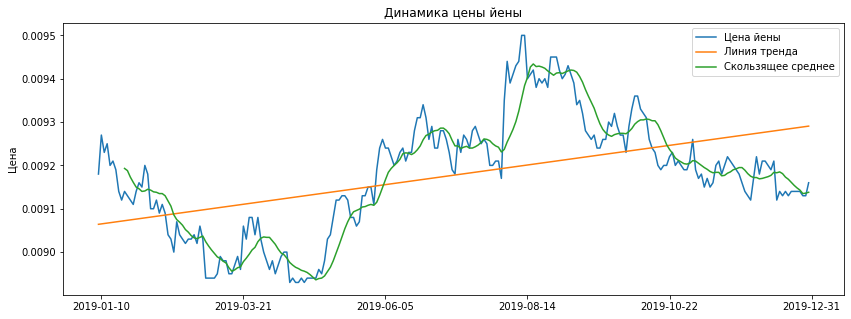

In [25]:
pyplot.figure(figsize=(14,5))
pyplot.plot(y, label="Цена йены")
pyplot.plot(y_model, label="Линия тренда")
pyplot.plot(y.rolling(10).mean(), label="Скользящее среднее")
pyplot.title("Динамика цены йены")
pyplot.ylabel("Цена")
labels=H["Date"].apply(lambda x : datetime.strftime(x, "%Y-%m-%d"))
pyplot.xticks(ticks=x[::49], labels=labels[::49])
pyplot.legend();

Рассчитаем $R^2$
$$
R^2 = \frac{D_y-D_\epsilon}{D_y}
$$
где $D_y$ - дисперсия цены, $D_\epsilon$ - дисперсия остатков

In [26]:
disp_y = np.std(y)**2
disp_epsilon = np.sum((y - y_model)**2/n)
R2 = (disp_y - disp_epsilon) / disp_y
print(round(R2,3))

0.236


Гистограмма остатков модели

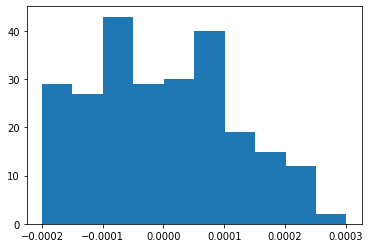

In [27]:
pyplot.hist(y-y_model);

Гистограмма остатков сглаженного ряда

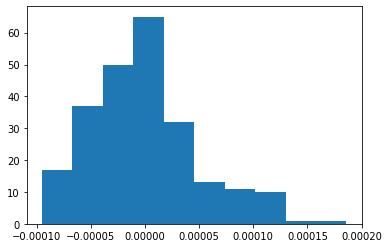

In [28]:
pyplot.hist(y-y.rolling(10).mean());